<a href="https://colab.research.google.com/github/dongvt/MLData/blob/main/Personal_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Note: After you run this cell, the training and test data will be available in
# the file browser. (Click the folder icon on the left to view it)
#
# If you don't see the data after the cell completes, click the refresh button
# in the file browser (folder icon with circular arrow)

# First, let's download and unzip the data
!echo "Downloading files..."
!wget -q https://github.com/dongvt/MLData/raw/main/test.rar
!wget -q https://github.com/dongvt/MLData/raw/main/training1.rar
!wget -q https://github.com/dongvt/MLData/raw/main/training2.rar
!wget -q https://github.com/dongvt/MLData/raw/main/training3.rar
!wget -q https://github.com/dongvt/MLData/raw/main/meta-data.csv

!echo "Unzipping files..."
!unrar x /content/training1.rar /content/training/
!unrar x /content/training2.rar /content/
!unrar x /content/training3.rar /content/
!unrar x /content/test.rar /content/

# # Combine the two traning directories
!echo "Mergining shoes data..."
!mkdir /content/training/Shoes
!mv /content/Shoes1/* /content/training/Shoes
!mv /content/Shoes2/* /content/training/Shoes

# # Cleanup
!echo "Cleaning up..."
!rmdir /content/Shoes1
!rmdir /content/Shoes2
!rm training1.rar
!rm training2.rar
!rm training3.rar
!rm test.rar


!echo "Data ready."

Streaming output truncated to the last 5000 lines.
Extracting  /content/Shoes2/7983596.193254.jpg                            99%  OK 
Extracting  /content/Shoes2/7983596.20.jpg                                99%  OK 
Extracting  /content/Shoes2/7983598.3.jpg                                 99%  OK 
Extracting  /content/Shoes2/7983598.336.jpg                               99%  OK 
Extracting  /content/Shoes2/7983600.45499.jpg                             99%  OK 
Extracting  /content/Shoes2/7983602.139.jpg                               99%  OK 
Extracting  /content/Shoes2/7983602.20704.jpg                             99%  OK 
Extracting  /content/Shoes2/7983602.48541.jpg                             99%  OK 
Extracting  /content/Shoes2/7983602.6700.jpg                              99%  OK 
Extracting  /content/Shoes2/7983784.358520.jpg                            99%  OK 
Extracting  /content/Shoes2/7

In [2]:
# Import libraries
import pandas as pd
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import numpy as np


In [3]:
# Create an image training dataset
from tensorflow.keras.preprocessing import image_dataset_from_directory

# We're using keras' image_dataset_from_directory method to load our image data.
# See (https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory) for details
#
# A couple of things to note:
# 1. We're specifying a number for the seed, so we'll always get the same shuffle and split of our images.
# 2. Class names are inferred automatically from the image subdirectory names.
# 3. We're splitting the training data into 80% training, 20% validation. 


training_dir = '/content/training/'
image_size = (136, 102)

# Split up the training data images into training and validations sets
training_data = image_dataset_from_directory(training_dir, validation_split=.2, subset='training', seed=42, image_size=image_size)
validation_data = image_dataset_from_directory(training_dir, validation_split=.2, subset='validation', seed=42, image_size=image_size)

Found 45081 files belonging to 4 classes.
Using 36065 files for training.
Found 45081 files belonging to 4 classes.
Using 9016 files for validation.


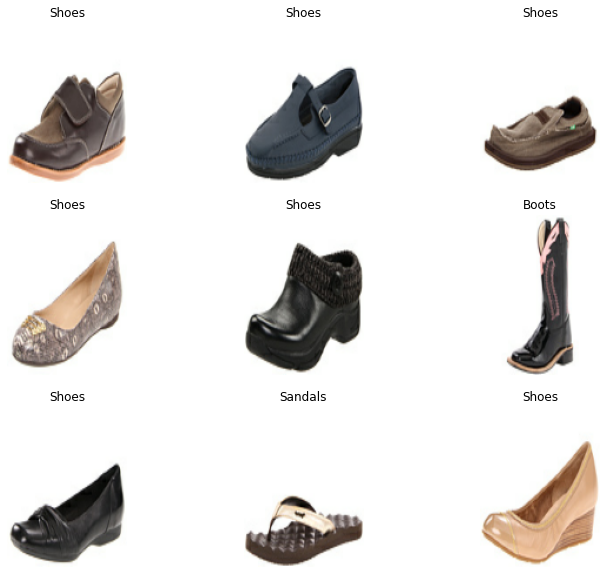

In [4]:
import matplotlib.pyplot as plt

# View first 9 images and their class labels
plt.figure(figsize=(12, 10))
for images, labels in training_data.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(training_data.class_names[labels[i]])
    plt.axis("off")

In [5]:
data_augmentation = keras.Sequential(
  [
    # layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(100, 100,3)),
    layers.experimental.preprocessing.RandomRotation(0.2,input_shape=(136, 102,3)),
    layers.experimental.preprocessing.RandomZoom(0.1),
    layers.experimental.preprocessing.RandomContrast(0.5, seed=42),
  ]
)

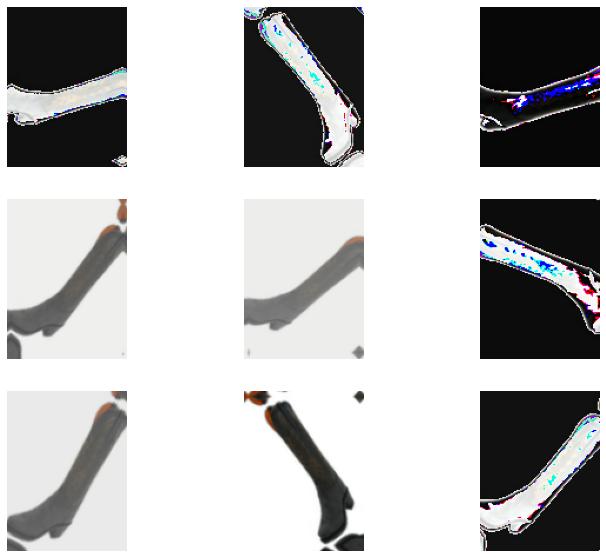

In [6]:
plt.figure(figsize=(12, 10))
for images, _ in training_data.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [7]:
num_classes = 43

model = Sequential([
  data_augmentation,           
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(136, 102, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [8]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 136, 102, 3)       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 136, 102, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 136, 102, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 68, 51, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 68, 51, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 34, 25, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 25, 64)       

In [9]:
epochs=10
history = model.fit(
  training_data,
  validation_data=validation_data,
  epochs=epochs
)

Epoch 1/10
1128/1128 [==============================] - 70s 34ms/step - loss: 0.5783 - accuracy: 0.7937 - val_loss: 0.3764 - val_accuracy: 0.8689
Epoch 2/10
1128/1128 [==============================] - 39s 35ms/step - loss: 0.3885 - accuracy: 0.8627 - val_loss: 0.3104 - val_accuracy: 0.8949
Epoch 3/10
1128/1128 [==============================] - 40s 35ms/step - loss: 0.3208 - accuracy: 0.8879 - val_loss: 0.2582 - val_accuracy: 0.9086
Epoch 4/10
1128/1128 [==============================] - 38s 33ms/step - loss: 0.2897 - accuracy: 0.8987 - val_loss: 0.3016 - val_accuracy: 0.9069
Epoch 5/10
1128/1128 [==============================] - 39s 34ms/step - loss: 0.2650 - accuracy: 0.9064 - val_loss: 0.2565 - val_accuracy: 0.9142
Epoch 6/10
1128/1128 [==============================] - 39s 35ms/step - loss: 0.2482 - accuracy: 0.9120 - val_loss: 0.2605 - val_accuracy: 0.9166
Epoch 7/10
1128/1128 [==============================] - 40s 36ms/step - loss: 0.2393 - accuracy: 0.9140 - val_loss: 0.2429 -

In [10]:
realShoes = pd.read_csv('https://github.com/dongvt/MLData/raw/main/meta-data.csv')


import pathlib

def predict_an_image(model, file_path):
  # Load the image
  img = keras.preprocessing.image.load_img(file_path, target_size=(136, 102))
  
  # Get the image into the shape we need for our network
  img_array = keras.preprocessing.image.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0)
  # Predict the class
  predictions = model.predict(img_array)
  score = tf.nn.softmax(predictions[0])
  return np.argmax(score)


def get_row_prediction(row):
  return predict_an_image(model, '/content/Test/' + row['CID'])


realShoes['predicted'] = realShoes.apply(get_row_prediction, axis=1)


In [11]:
realShoes

,CID,Category,predicted
0,7622094.393297.jpg,Sandals,2
1,7622623.18.jpg,Sandals,1
2,7622629.10881.jpg,Sandals,1
3,7622629.10883.jpg,Sandals,2
4,7622629.217.jpg,Sandals,2
...,...,...,...
4553,8021057.3924.jpg,Slippers,3
4554,8021058.2427.jpg,Slippers,2
4555,8021065.2247.jpg,Slippers,2
4556,8021068.2247.jpg,Slippers,0


In [12]:
realShoes['predictedClass'] = realShoes['predicted'].map({
1:'Sandals',
0:'Boots',
2:'Shoes',
3:'Slippers'
})

realShoes['bin_crnn'] = (realShoes['predictedClass']==realShoes['Category']).astype(int)
sum(realShoes["bin_crnn"])/4558

0.9293549802544976